# ***ATTENZIONE***
In tutto il notebook gli outliers sono stati indicati con -1 all interno del dataset, gli inlier con 1.

In [1]:
#pip install numpy==1.21

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from collections import Counter
from collections import defaultdict
from sklearn.feature_selection import SelectKBest

from sklearn.preprocessing import StandardScaler

from pyod.models.hbos import HBOS

from sklearn.covariance import EllipticEnvelope

from pyod.models.knn import KNN

from sklearn.neighbors import LocalOutlierFactor

from pyod.models.cof import COF

from sklearn.cluster import DBSCAN

from pyod.models.cblof import CBLOF

from pyod.models.abod import ABOD

from pyod.models.loda import LODA

from sklearn.ensemble import IsolationForest
from pyod.models.iforest import IsolationForest

In [3]:
df_train=pd.read_csv("../ravdess_features_train_pulito.csv")
df_test=pd.read_csv("../ravdess_features_test_pulito.csv")

df_train["emotion"]=df_train["emotion"].replace(["fearful", "angry", "happy", "surprised", "neutral", "calm", "sad", "disgust"],[0,1,2,3,4,5,6,7])
df_train["emotional_intensity"]=df_train["emotional_intensity"].replace(["normal", "strong"],[0,1])
df_train["sex"]=df_train["sex"].replace(["M", "F"],[0,1])
df_train["statement"]=df_train["statement"].replace(["Dogs are sitting by the door", "Kids are talking by the door"],[0,1])
df_train["vocal_channel"]=df_train["vocal_channel"].replace(["speech", "song"],[0,1])
y_train=df_train.emotion.values
X_train=df_train.drop(columns=["emotion"]).values

df_test["emotion"]=df_test["emotion"].replace(["fearful", "angry", "happy", "surprised", "neutral", "calm", "sad", "disgust"],[0,1,2,3,4,5,6,7])
df_test["emotional_intensity"]=df_test["emotional_intensity"].replace(["normal", "strong"],[0,1])
df_test["sex"]=df_test["sex"].replace(["M", "F"],[0,1])
df_test["statement"]=df_test["statement"].replace(["Dogs are sitting by the door", "Kids are talking by the door"],[0,1])
df_test["vocal_channel"]=df_test["vocal_channel"].replace(["speech", "song"],[0,1])
y_test=df_test.emotion.values
X_test=df_test.drop(columns=["emotion"]).values

In [4]:
frames = [df_train, df_test]
df = pd.concat(frames, ignore_index=True)
X = df.drop(columns=["emotion"]).values
X_unscaled = df.drop(columns=["emotion"]).values
y=df.emotion.values

In [5]:
sel = SelectKBest(k=108)
X = sel.fit_transform(X, y)

In [6]:
features = sel.get_feature_names_out()
features = ([s.replace("x", "") for s in features])
df.T.iloc[features].T.head()

,vocal_channel,sex,mean,std,min,max,q01,q75,q95,lag1_mean,...,mfcc_std_w3,mfcc_max_w3,mfcc_q01_w3,mfcc_kur_w3,stft_skew_w3,std_w4,min_w4,lag1_std_w4,lag1_min_w4,zc_skew_w4
0,0.0,0.0,9.150000e-07,0.004001,-0.038422,0.040588,-0.012586,0.0,0.005676,0.000000e+00,...,147.423418,240.630021,-734.485522,14.901427,0.288573,0.000013,-0.000122,0.000011,-0.000061,3.922259
1,0.0,0.0,7.137790e-07,0.004283,-0.042603,0.048157,-0.013550,0.0,0.005920,0.000000e+00,...,144.564137,222.035063,-698.629767,14.429526,0.513204,0.000018,-0.000244,0.000010,-0.000061,4.613060
2,0.0,0.0,9.554485e-07,0.005084,-0.037018,0.058472,-0.015822,0.0,0.007263,-3.888704e-10,...,144.489909,231.626338,-698.875743,14.459248,0.474012,0.000012,-0.000122,0.000009,-0.000092,5.079725
3,0.0,0.0,9.176213e-07,0.004886,-0.036652,0.062683,-0.014923,0.0,0.006470,-2.005743e-10,...,144.062098,218.239004,-699.412515,14.314860,0.239217,0.000024,-0.000244,0.000015,-0.000092,3.369546
4,0.0,0.0,8.108948e-07,0.002956,-0.026245,0.026215,-0.009399,0.0,0.004242,-1.797605e-10,...,144.892061,229.730841,-690.419475,13.218938,0.575065,0.000023,-0.000305,0.000013,-0.000061,3.937357


In [7]:
X.shape

(2452, 108)

In [8]:
scl = StandardScaler()
X = scl.fit_transform(X)

# Visual Based

## HBOS

In [9]:
clf = HBOS(n_bins=20)
clf.fit(X)
clf.decision_scores_

array([ 51.05939133,  47.26402508,  53.96083564, ..., 150.39595341,
       159.6243074 , 197.13622337])

In [10]:
outliers = clf.predict(X)
print(np.unique(outliers, return_counts=True))
print(np.unique(outliers, return_counts=True)[1][1]/len(X))

(array([0, 1]), array([2206,  246]))
0.100326264274062


In [11]:
for i in range(len(outliers)):
    if outliers[i] == 1:
        outliers[i] = -1
    else:
        outliers[i] = 1
outliers

array([1, 1, 1, ..., 1, 1, 1])

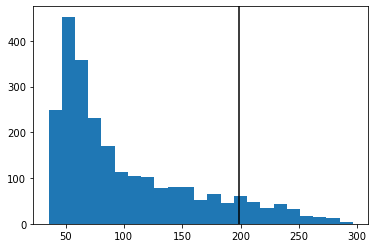

In [12]:
plt.hist(clf.decision_scores_, bins="auto")
plt.axvline(np.min(clf.decision_scores_[np.where(outliers==-1)]), c='k')
plt.show()

# Depth Based

## Elliptic Envelope

In [13]:
ellenv = EllipticEnvelope(random_state=0)
ellenv.fit(X)
outliers = ellenv.predict(X)

/Users/jacopogneri/opt/anaconda3/lib/python3.9/site-packages/sklearn/covariance/_robust_covariance.py:738: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(
/Users/jacopogneri/opt/anaconda3/lib/python3.9/site-packages/sklearn/covariance/_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-705.090765875564102 > -705.260015475310865). You may want to try with a higher value of support_fraction (current value: 0.523).
  warnings.warn(
/Users/jacopogneri/opt/anaconda3/lib/python3.9/site-packages/sklearn/covariance/_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-703.510183526128685 > -704.225130835047707). You may want to try with a higher value of support_fraction (current value: 0.523).
  warnings.warn(
/Users/jacopogneri/opt/anaconda3/lib/python3.9/site-packages/sklearn/covariance/_robust_covaria

In [14]:
np.unique(outliers, return_counts=True)

(array([-1,  1]), array([ 246, 2206]))

In [15]:
#df["outliers_elliptic_envelope"] = outliers

In [16]:
#df.iloc[np.where(df.outliers_elliptic_envelope == -1)].head()

# Distance Based

## KNN

In [17]:
clf = KNN(n_neighbors=2, method="largest", p=2, n_jobs=-1)
clf.fit(X)
outliers = clf.predict(X)
np.unique(outliers, return_counts=True)

(array([0, 1]), array([2280,  172]))

In [18]:
for i in range(len(outliers)):
    if outliers[i] == 0:
        outliers[i] = 1
    else:
        outliers[i] = -1
outliers

array([1, 1, 1, ..., 1, 1, 1])

In [19]:
#df["outliers_knn"] = outliers

In [20]:
#df.iloc[np.where(df.outliers_knn == -1)].head()

In [21]:
'''
outliers_list_knn = []
for i in range(2,50):
    clf = KNN(n_neighbors=i, method="largest", p=2, n_jobs=-1)
    clf.fit(X)
    outliers = clf.predict(X)
    outliers_list_knn.append(np.unique(outliers, return_counts=True)[1][1])

plt.scatter(x=np.arange(2,50), y=outliers_list_knn)
plt.show()
'''
#tempo di esecuzione circa 2 minuti

'\noutliers_list_knn = []\nfor i in range(2,50):\n    clf = KNN(n_neighbors=i, method="largest", p=2, n_jobs=-1)\n    clf.fit(X)\n    outliers = clf.predict(X)\n    outliers_list_knn.append(np.unique(outliers, return_counts=True)[1][1])\n\nplt.scatter(x=np.arange(2,50), y=outliers_list_knn)\nplt.show()\n'

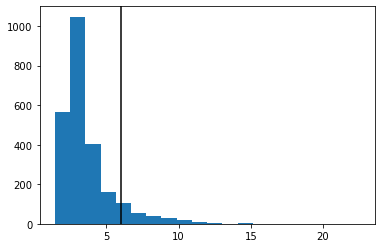

In [22]:
plt.hist(clf.decision_scores_, bins=20)
plt.axvline(np.min(clf.decision_scores_[np.where(outliers==-1)]), c='k')
plt.show()

# Density Based

## LOF

In [23]:
'''
outliers_list_lof = []
for i in range(1,300):
    clf = LocalOutlierFactor(n_neighbors=i, novelty = False)
    clf.fit(X)
    outliers = clf.fit_predict(X)
    outliers_list_lof.append(np.unique(outliers, return_counts=True)[1][0])

plt.scatter(x=np.arange(1,300), y=outliers_list_lof)
plt.show()
'''
#tempo di esecuzione circa 2m40s. Minimo per n_neighbor=3 con 64 outliers

'\noutliers_list_lof = []\nfor i in range(1,300):\n    clf = LocalOutlierFactor(n_neighbors=i, novelty = False)\n    clf.fit(X)\n    outliers = clf.fit_predict(X)\n    outliers_list_lof.append(np.unique(outliers, return_counts=True)[1][0])\n\nplt.scatter(x=np.arange(1,300), y=outliers_list_lof)\nplt.show()\n'

In [24]:
clf = LocalOutlierFactor(n_neighbors=3, novelty = False, n_jobs=-1)
clf.fit(X)
outliers = clf.fit_predict(X)
np.unique(outliers, return_counts=True)

(array([-1,  1]), array([  43, 2409]))

In [25]:
NLOF = clf.negative_outlier_factor_ #the higher the more normal
ind = np.argpartition(NLOF, int(len(df)*0.01))[:int(len(df)*0.01)] # indice dei top 1% outliers
ind

array([1990, 2392,  899,  352,  234, 1970, 1981, 1879,  935, 1067,  698,
       2057, 1968, 1882,  815, 2375,  589, 1982, 1957, 1765, 2227, 1845,
       1815,  546])

In [26]:
df["outliers_LOF"] = 0
for i in range(len(df)):
    if i in ind:
        df["outliers_LOF"][i] = -1
    else:
        df["outliers_LOF"][i] = 1

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_6357/4215259980.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_LOF"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_6357/4215259980.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_LOF"][i] = -1


In [27]:
df.iloc[np.where(df.outliers_LOF == -1)]

,vocal_channel,emotion,emotional_intensity,statement,sex,frame_count,sum,mean,std,min,...,stft_std_w4,stft_min_w4,stft_q01_w4,stft_q05_w4,stft_q25_w4,stft_q50_w4,stft_q75_w4,stft_kur_w4,stft_skew_w4,outliers_LOF
234,0,6,1,0,0,166566,-1.252472,-7.519373e-06,0.032619,-0.360992,...,0.240487,0.034541,0.074704,0.218413,0.597664,0.792696,0.924666,0.156586,-0.969812,-1
352,0,0,1,1,1,188989,-0.173004,-9.154192e-07,0.041938,-0.357300,...,0.297645,0.026015,0.050132,0.074913,0.186668,0.375093,0.677906,-0.977898,0.520642,-1
546,0,6,1,0,1,221020,0.617218,2.792589e-06,0.015362,-0.233215,...,0.255465,0.012430,0.033260,0.111236,0.496639,0.676464,0.838886,-0.282704,-0.614345,-1
589,1,5,1,1,1,304304,-0.247406,-8.130225e-07,0.007213,-0.038147,...,0.244130,0.000000,0.000000,0.000000,0.000000,0.000000,0.007891,7.127631,2.880807,-1
698,1,2,0,0,0,208208,-3.728546,-1.790779e-05,0.007680,-0.058197,...,0.263412,0.032913,0.049182,0.114918,0.705369,0.851904,0.961261,1.077045,-1.457242,-1
815,1,6,1,0,1,238638,-0.353271,-1.480366e-06,0.013606,-0.137970,...,0.281130,0.033783,0.059296,0.115940,0.317708,0.539619,0.792487,-1.158128,0.075584,-1
899,1,5,0,0,0,235435,-0.222931,-9.468894e-07,0.009356,-0.055695,...,0.312810,0.006918,0.011874,0.031803,0.363612,0.663677,0.848071,-0.990703,-0.503741,-1
935,1,0,1,0,0,198598,-0.564178,-2.840806e-06,0.014016,-0.138062,...,0.291799,0.013814,0.025942,0.098914,0.371273,0.672929,0.866585,-1.051031,-0.422723,-1
1067,0,6,1,0,0,160160,-0.385742,-2.408480e-06,0.015684,-0.158112,...,0.276639,0.006583,0.011082,0.046899,0.578094,0.785651,0.931819,0.465945,-1.140579,-1
1765,1,0,1,1,0,211411,-26.329529,-1.245419e-04,0.038981,-0.369354,...,0.301387,0.024696,0.042141,0.075505,0.206936,0.409403,0.736794,-1.174018,0.378637,-1


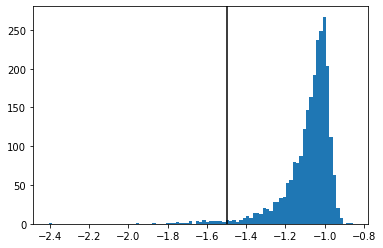

In [28]:
plt.hist(clf.negative_outlier_factor_, bins="auto")
plt.axvline(np.min(clf.negative_outlier_factor_[np.where(outliers==1)]), c='k')
plt.show()

## COF

In [29]:
clf = COF(n_neighbors=5)
clf.fit(X)
outliers = clf.predict(X)
np.unique(outliers, return_counts=True)

(array([0, 1]), array([2206,  246]))

In [30]:
for i in range(len(outliers)):
    if outliers[i] == 0:
        outliers[i] = 1
    else:
        outliers[i] = -1
outliers

array([1, 1, 1, ..., 1, 1, 1])

In [31]:
#df["outliers_cof"] = outliers

In [32]:
#df.iloc[np.where(df.outliers_cof == -1)]

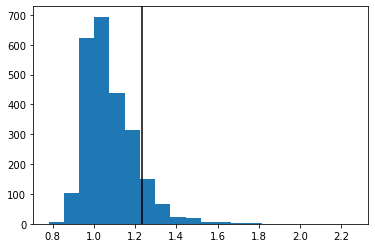

In [33]:
plt.hist(clf.decision_scores_, bins=20)
plt.axvline(np.min(clf.decision_scores_[np.where(outliers==-1)]), c='k')
plt.show()

# Cluster Based

## DBSCAN

In [34]:
outliers=[]
for i in range(1,20):    
    dbscan = DBSCAN(eps=i, min_samples=5)
    dbscan.fit(X)
    outliers.append((dbscan.labels_==-1).sum())
np.unique(outliers, return_counts=True)

(array([   1,    2,    3,    4,    7,    8,   11,   24,   48,   71,  100,
         151,  242,  349,  592, 1336, 2413, 2452]),
 array([1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]))

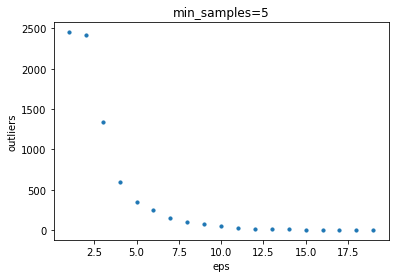

In [35]:
plt.scatter(x=range(1,20), y=outliers, s=10)
plt.xlabel("eps")
plt.ylabel("outliers")
plt.title("min_samples=5")
plt.show()

## CBLOF

In [36]:

outliers_list_cblof = []
for i in range(3,30):
    clf = CBLOF(n_clusters=i, alpha=0.5, beta=3)
    clf.fit(X)
    outliers = clf.predict(X)
    print(np.unique(outliers, return_counts=True))
    outliers_list_cblof.append(np.unique(outliers, return_counts=True)[1][1])

#len(outliers_list_cblof)
#outliers_list_cblof

(array([0, 1]), array([2206,  246]))
(array([0, 1]), array([2206,  246]))
(array([0, 1]), array([2206,  246]))
(array([0, 1]), array([2206,  246]))
(array([0, 1]), array([2206,  246]))
(array([0, 1]), array([2206,  246]))
(array([0, 1]), array([2206,  246]))
(array([0, 1]), array([2206,  246]))
(array([0, 1]), array([2206,  246]))
(array([0, 1]), array([2206,  246]))
(array([0, 1]), array([2206,  246]))
(array([0, 1]), array([2206,  246]))
(array([0, 1]), array([2206,  246]))
(array([0, 1]), array([2206,  246]))
(array([0, 1]), array([2206,  246]))
(array([0, 1]), array([2206,  246]))
(array([0, 1]), array([2206,  246]))
(array([0, 1]), array([2206,  246]))
(array([0, 1]), array([2206,  246]))
(array([0, 1]), array([2206,  246]))
(array([0, 1]), array([2206,  246]))
(array([0, 1]), array([2206,  246]))
(array([0, 1]), array([2206,  246]))
(array([0, 1]), array([2206,  246]))
(array([0, 1]), array([2206,  246]))
(array([0, 1]), array([2206,  246]))
(array([0, 1]), array([2206,  246]))


In [37]:
OS = clf.decision_scores_ #the lower the more normal
ind = np.argpartition(OS, -int(len(df)*0.01))[-int(len(df)*0.01):] # indice dei top 1% outliers
ind

array([1704, 1594, 1966,  658,  241,  240, 1801,  346, 1075,  243, 1757,
       1803, 1878, 1964, 2026, 2234, 1975,  563, 1862,  234,  659, 1283,
       1861,   35])

In [38]:
df["outliers_CBLOF"] = 0
for i in range(len(df)):
    if i in ind:
        df["outliers_CBLOF"][i] = -1
    else:
        df["outliers_CBLOF"][i] = 1

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_6357/3000840312.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_CBLOF"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_6357/3000840312.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_CBLOF"][i] = -1


In [39]:
df.iloc[np.where(df.outliers_CBLOF == -1)].head()

,vocal_channel,emotion,emotional_intensity,statement,sex,frame_count,sum,mean,std,min,...,stft_min_w4,stft_q01_w4,stft_q05_w4,stft_q25_w4,stft_q50_w4,stft_q75_w4,stft_kur_w4,stft_skew_w4,outliers_LOF,outliers_CBLOF
35,0,1,1,0,0,213013,-9.211029,-0.000043,0.149701,-0.971649,...,0.035675,0.070545,0.122659,0.292612,0.484957,0.751114,-1.098503,0.225204,1,-1
234,0,6,1,0,0,166566,-1.252472,-0.000008,0.032619,-0.360992,...,0.034541,0.074704,0.218413,0.597664,0.792696,0.924666,0.156586,-0.969812,-1,-1
240,0,1,1,1,0,211411,-4.979034,-0.000024,0.089317,-0.963928,...,0.066911,0.108532,0.232051,0.517947,0.706479,0.873016,-0.566148,-0.498224,1,-1
241,0,1,1,1,0,211412,7.284607,0.000034,0.087604,-0.998810,...,0.029732,0.119145,0.266537,0.520887,0.692956,0.856511,-0.483418,-0.449991,1,-1
243,0,1,1,0,0,216216,-0.476227,-0.000002,0.104572,-0.944122,...,0.078238,0.115917,0.221915,0.466304,0.629270,0.809098,-0.688100,-0.164156,1,-1


In [40]:
outliers

array([0, 0, 0, ..., 0, 0, 0])

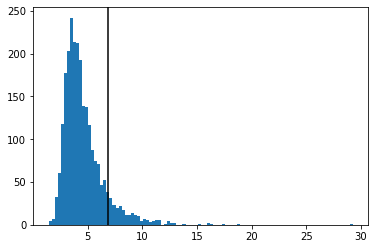

In [41]:
plt.hist(clf.decision_scores_, bins="auto")
plt.axvline(np.min(clf.decision_scores_[np.where(outliers==1)]), c='k')
plt.show()

# Angle Based

## ABOD

/Users/jacopogneri/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jacopogneri/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jacopogneri/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(array([0, 1]), array([   2, 2450]))
(array([0, 1]), array([2073,  379]))
(array([0, 1]), array([2178,  274]))
(array([0, 1]), array([2198,  254]))
(array([0, 1]), array([2201,  251]))
(array([0, 1]), array([2204,  248]))
(array([0, 1]), array([2208,  244]))
(array([0, 1]), array([2207,  245]))
(array([0, 1]), array([2217,  235]))
(array([0, 1]), array([2213,  239]))
(array([0, 1]), array([2213,  239]))
(array([0, 1]), array([2214,  238]))


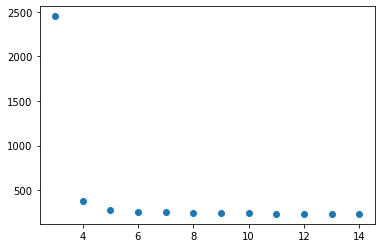

In [42]:

outliers_list_abod = []
for i in range(3,15):
    clf = ABOD(n_neighbors=i)
    clf.fit(X)
    outliers = clf.predict(X)
    outliers_list_abod.append(np.unique(outliers, return_counts=True)[1][1])
    print(np.unique(outliers, return_counts=True))
    
plt.scatter(x=np.arange(3,15), y=outliers_list_abod)
plt.show()


In [43]:
np.unique(outliers, return_counts=True)

(array([0, 1]), array([2214,  238]))

In [44]:
OS = clf.decision_scores_ #the lower the more normal
ind = np.argpartition(OS, -int(len(df)*0.01))[-int(len(df)*0.01):] # indice dei top 1% outliers
ind

array([1757,  761,  241, 1878, 1975, 1964, 2025, 2024,  555,  554, 2027,
       1031,  346, 1075,  658,  563, 2026,  243, 1283,  659,   35, 1861,
       1862,  234])

In [45]:
num = np.argpartition(OS, -int(len(df)*1))[-int(len(df)*1):] # indice dei top 1% outliers
len(num)

2452

In [46]:
df["outliers_ABOD"] = 0
for i in range(len(df)):
    if i in ind:
        df["outliers_ABOD"][i] = -1
    else:
        df["outliers_ABOD"][i] = 1

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_6357/3807823159.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_ABOD"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_6357/3807823159.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_ABOD"][i] = -1


In [47]:
df.iloc[np.where(df.outliers_ABOD == -1)]

,vocal_channel,emotion,emotional_intensity,statement,sex,frame_count,sum,mean,std,min,...,stft_q01_w4,stft_q05_w4,stft_q25_w4,stft_q50_w4,stft_q75_w4,stft_kur_w4,stft_skew_w4,outliers_LOF,outliers_CBLOF,outliers_ABOD
35,0,1,1,0,0,213013,-9.211029,-4.324163e-05,0.149701,-0.971649,...,0.070545,0.122659,0.292612,0.484957,0.751114,-1.098503,0.225204,1,-1,-1
234,0,6,1,0,0,166566,-1.252472,-7.519373e-06,0.032619,-0.360992,...,0.074704,0.218413,0.597664,0.792696,0.924666,0.156586,-0.969812,-1,-1,-1
241,0,1,1,1,0,211412,7.284607,3.445692e-05,0.087604,-0.998810,...,0.119145,0.266537,0.520887,0.692956,0.856511,-0.483418,-0.449991,1,-1,-1
243,0,1,1,0,0,216216,-0.476227,-2.202551e-06,0.104572,-0.944122,...,0.115917,0.221915,0.466304,0.629270,0.809098,-0.688100,-0.164156,1,-1,-1
346,0,1,1,0,1,177777,-0.004974,-2.798093e-08,0.072248,-0.862366,...,0.289735,0.371105,0.554598,0.702927,0.851481,-0.856788,-0.147625,1,-1,-1
554,0,1,1,0,1,213013,0.785797,3.688963e-06,0.091451,-0.633057,...,0.016566,0.041669,0.294650,0.659654,0.854806,-1.151544,-0.429745,1,1,-1
555,0,1,1,0,1,214614,0.211212,9.841490e-07,0.088013,-0.676880,...,0.063484,0.114294,0.292658,0.588257,0.806210,-1.262910,-0.082460,1,1,-1
563,0,0,1,0,1,179379,-0.203125,-1.132379e-06,0.121231,-0.727966,...,0.027173,0.050573,0.133121,0.250091,0.519727,-0.175535,1.000085,1,-1,-1
658,0,1,1,0,0,184184,-6.383972,-3.466084e-05,0.120286,-0.976166,...,0.168465,0.339421,0.667964,0.808485,0.929470,0.928971,-1.099596,1,-1,-1
659,0,1,1,0,0,208208,2.806671,1.348013e-05,0.096210,-0.763763,...,0.146228,0.348227,0.740867,0.877829,0.969386,1.752002,-1.479197,1,-1,-1


In [48]:
'''plt.hist(clf.decision_scores_, bins="auto")
plt.axvline(np.min(clf.decision_scores_[np.where(outliers==1)]), c='k')
plt.xlim((-3e-5,0.2e-5))
plt.show()'''

'plt.hist(clf.decision_scores_, bins="auto")\nplt.axvline(np.min(clf.decision_scores_[np.where(outliers==1)]), c=\'k\')\nplt.xlim((-3e-5,0.2e-5))\nplt.show()'

# Ensemble Based

## LODA

In [49]:

outliers_list_loda = []
for i in range(1,30):
    clf = LODA(n_bins="auto", n_random_cuts=i)
    clf.fit(X)
    outliers = clf.predict(X)
    outliers_list_loda.append(np.unique(outliers, return_counts=True)[1][1])
    print(np.unique(outliers, return_counts=True))

(array([0, 1]), array([2450,    2]))
(array([0, 1]), array([2228,  224]))
(array([0, 1]), array([2229,  223]))
(array([0, 1]), array([2206,  246]))
(array([0, 1]), array([2232,  220]))
(array([0, 1]), array([2213,  239]))
(array([0, 1]), array([2206,  246]))
(array([0, 1]), array([2214,  238]))
(array([0, 1]), array([2206,  246]))
(array([0, 1]), array([2206,  246]))
(array([0, 1]), array([2206,  246]))
(array([0, 1]), array([2206,  246]))
(array([0, 1]), array([2206,  246]))
(array([0, 1]), array([2218,  234]))
(array([0, 1]), array([2212,  240]))
(array([0, 1]), array([2207,  245]))
(array([0, 1]), array([2207,  245]))
(array([0, 1]), array([2206,  246]))
(array([0, 1]), array([2206,  246]))
(array([0, 1]), array([2206,  246]))
(array([0, 1]), array([2206,  246]))
(array([0, 1]), array([2206,  246]))
(array([0, 1]), array([2206,  246]))
(array([0, 1]), array([2206,  246]))
(array([0, 1]), array([2206,  246]))
(array([0, 1]), array([2206,  246]))
(array([0, 1]), array([2206,  246]))
(

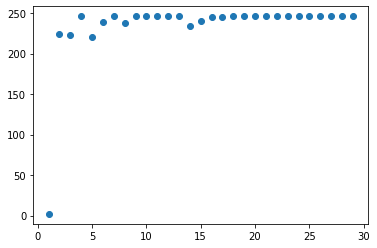

In [50]:
plt.scatter(x=np.arange(1,30), y=outliers_list_loda)
plt.show()

In [51]:
OS = clf.decision_scores_ #the lower the more normal
ind = np.argpartition(OS, -int(len(df)*0.01))[-int(len(df)*0.01):] # indice dei top 1% outliers
ind

array([ 240, 2234,  241, 1801,  242, 1029,  553,  555, 1075,   35,  554,
       2027, 2026, 1861, 2024, 1030, 1031,  658, 2235,  659, 1283,  243,
       1862, 2025])

In [52]:
df["outliers_LODA"] = 0
for i in range(len(df)):
    if i in ind:
        df["outliers_LODA"][i] = -1
    else:
        df["outliers_LODA"][i] = 1

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_6357/825742444.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_LODA"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_6357/825742444.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_LODA"][i] = -1


KeyboardInterrupt: 

In [ ]:
df.iloc[np.where(df.outliers_LODA == -1)]

In [ ]:
plt.hist(clf.decision_scores_, bins=20)
plt.axvline(np.min(clf.decision_scores_[np.where(outliers==1)]), c='k')
plt.show()

# Model Based

## Isolation Forest

In [ ]:
'''
outliers_list_isoforest = []
for i in range(1,110):
    clf = IsolationForest(random_state=0, n_jobs=-1, n_estimators=i)
    clf.fit(X_train)
    outliers = clf.predict(X_test)
    outliers_list_isoforest.append(np.unique(outliers, return_counts=True)[1][0])

plt.scatter(x=np.arange(1,110), y=outliers_list_isoforest)
plt.show()
'''

In [ ]:
outliers_list_isoforest = []
for i in range(1,60):
    clf = IsolationForest(random_state=0, n_jobs=-1, n_estimators=i)
    clf.fit(X)
    outliers = clf.predict(X)
    outliers_list_isoforest.append(np.unique(outliers, return_counts=True)[1][0])
    print(np.unique(outliers, return_counts=True))
    
plt.scatter(x=np.arange(1,60), y=outliers_list_isoforest)
plt.show()

In [ ]:
plt.scatter(x=np.arange(0,len(clf.decision_function(X))), y=clf.decision_function(X))
plt.scatter(x=np.arange(0,len(clf.score_samples(X))), y=clf.score_samples(X))
plt.show()
# questo vuol dire che le due funzioni vogliono dire la stessa cosa, ma decision_function è centrato attorno a zero

In [ ]:
clf = IsolationForest(random_state=0, n_jobs=-1, n_estimators=35)
clf.fit(X)
outliers = clf.predict(X)
print(np.unique(outliers, return_counts=True))

In [ ]:
OS = clf.decision_function(X) #the higher the more normal
ind = np.argpartition(OS, int(len(df)*0.01))[:int(len(df)*0.01)] # indice dei top 1% outliers
ind

In [ ]:
OS, OS[35], OS[np.where(OS < 0)] #Outliers have decision_function values less than 0

In [ ]:
df["outliers_ISOFOREST"] = 0
for i in range(len(df)):
    if i in ind:
        df["outliers_ISOFOREST"][i] = -1
    else:
        df["outliers_ISOFOREST"][i] = 1

In [ ]:
df.iloc[np.where(df.outliers_ISOFOREST == -1)].head()

# Statistical approach

## Grubb's test

In [ ]:
len(X)

In [ ]:
n = X.shape[0]
data = []
feature = 93
for i in range(X.shape[0]):
    data.append(X_unscaled[i][feature])
print(len(data))

In [ ]:
data = np.array(data)

In [ ]:
alpha = 0.95
significance_level = alpha/(2*n)
1-significance_level

In [ ]:
t = stats.t.isf(significance_level, n-2, 2)
t

In [ ]:
g_test = ((n-1) / np.sqrt(n)) * (np.sqrt(t**2 / (n-2 + t**2)))
g_test

In [ ]:
relative_values = abs(data - data.mean())
index = relative_values.argmax()
value = relative_values[index]

In [ ]:
g = value/data.std()

In [ ]:
if g > g_test:
    print('outlier')
else:
    print('inlier')

## Likelihood Approach

In [ ]:
def norm_dist(x, mu, sigma):
    return 1/(np.sqrt(2*np.pi)*sigma) * np.e**(-((x-mu)**2)/(2*sigma**2))
              
def unif_dist(x, n):
    return 1/n

In [ ]:
data = []
feature = 187
for i in range(X.shape[0]):
    data.append(X_unscaled[i][feature])
print(len(data))

In [ ]:
M = np.copy(data)
A = []
lambda_par = 0.3

muM = np.mean(M)
sigmaM = np.std(M)
sizeA = len(A)

sumM = np.sum([norm_dist(x, muM, sigmaM) for x in M])

sumA = np.sum([unif_dist(x, sizeA) for x in A])

ll = (len(M) * np.log(1-lambda_par) + sumM + len(A) * np.log(lambda_par) + sumA)

In [ ]:
M = np.copy(data)
A = []
c = 13656
for i, x in enumerate(data):
    A.append(x)
    M = np.array([xo for j, xo in enumerate(data) if i!=j])
    muM = np.mean(M)
    sigmaM = np.std(M)
    sizeA = len(A)
    sumM = np.sum([norm_dist(x, muM, sigmaM) for x in M])
    sumA = np.sum([unif_dist(x, sizeA) for x in A])
    ll_xi = (len(M) * np.log(1-lambda_par) + sumM + len(A) * np.log(lambda_par) + sumA)
    delta_ll = abs(ll - ll_xi)
    print(i, delta_ll, 'outlier' if delta_ll > c else 'inlier')
    M = np.copy(data)
    A = list()

# Deviation Based

In [ ]:
def sf(x, X):
    idx = list(X).index(x)
    X1 = np.array([x1 for i, x1 in enumerate(X) if i != idx])
    return np.abs(np.var(X) - np.var(X1))

In [ ]:
for i, x in enumerate(data):
    print(i, sf(x, data))

In [ ]:
np.var(data)

# Outliers Visualization through Dimensionality Reduction

In [ ]:
df

## ISOMAP

In [ ]:
from sklearn.manifold import Isomap

In [ ]:
iso = Isomap(n_components=2, n_jobs=-1)
X_iso = iso.fit_transform(X)
X_iso.shape

### LOF

In [ ]:
plt.scatter(X_iso[np.where(df.outliers_LOF == -1), 0], X_iso[np.where(df.outliers_LOF == -1), 1], edgecolor='k', alpha=1, label = "outliers", color = "red", zorder=2)
plt.scatter(X_iso[np.where(df.outliers_LOF == 1), 0], X_iso[np.where(df.outliers_LOF == 1), 1], edgecolor='k', alpha=0.3, label = "inliers", color = "lightblue", zorder=1)
plt.legend()
plt.show()

### CBLOF

In [ ]:
plt.scatter(X_iso[np.where(df.outliers_CBLOF == -1), 0], X_iso[np.where(df.outliers_CBLOF == -1), 1], edgecolor='k', alpha=1, label = "outliers", color = "red")
plt.scatter(X_iso[np.where(df.outliers_CBLOF == 1), 0], X_iso[np.where(df.outliers_CBLOF == 1), 1], edgecolor='k', alpha=0.3, label = "inliers", color = "lightblue")
plt.legend()
plt.show()

### ABOD

In [ ]:
plt.scatter(X_iso[np.where(df.outliers_ABOD == -1), 0], X_iso[np.where(df.outliers_ABOD == -1), 1], edgecolor='k', alpha=1, label = "outliers", color = "red")
plt.scatter(X_iso[np.where(df.outliers_ABOD == 1), 0], X_iso[np.where(df.outliers_ABOD == 1), 1], edgecolor='k', alpha=0.3, label = "inliers", color = "lightblue")
plt.legend()
plt.show()

### LODA

In [ ]:
plt.scatter(X_iso[np.where(df.outliers_LODA == -1), 0], X_iso[np.where(df.outliers_LODA == -1), 1], edgecolor='k', alpha=1, label = "outliers", color = "red")
plt.scatter(X_iso[np.where(df.outliers_LODA == 1), 0], X_iso[np.where(df.outliers_LODA == 1), 1], edgecolor='k', alpha=0.3, label = "inliers", color = "lightblue")
plt.legend()
plt.show()

### ISOFOREST

In [ ]:
plt.scatter(X_iso[np.where(df.outliers_ISOFOREST == -1), 0], X_iso[np.where(df.outliers_ISOFOREST == -1), 1], edgecolor='k', alpha=1, label = "outliers", color = "red")
plt.scatter(X_iso[np.where(df.outliers_ISOFOREST == 1), 0], X_iso[np.where(df.outliers_ISOFOREST == 1), 1], edgecolor='k', alpha=0.3, label = "inliers", color = "lightblue")
plt.legend()
plt.show()

## T-SNE

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
tsne = TSNE(n_components=2, learning_rate="auto", init="pca", n_jobs=-1)
X_tsne = tsne.fit_transform(X)
X_tsne.shape

### LOF

In [ ]:
plt.scatter(X_tsne[np.where(df.outliers_LODA == -1), 0], X_tsne[np.where(df.outliers_LODA == -1), 1], edgecolor='k', alpha=1, label = "outliers", color = "red")
plt.scatter(X_tsne[np.where(df.outliers_LODA == 1), 0], X_tsne[np.where(df.outliers_LODA == 1), 1], edgecolor='k', alpha=0.3, label = "inliers", color = "lightblue")
plt.legend()
plt.show()

### CBLOF

In [ ]:
plt.scatter(X_tsne[np.where(df.outliers_CBLOF == -1), 0], X_tsne[np.where(df.outliers_CBLOF == -1), 1], edgecolor='k', alpha=1, label = "outliers", color = "red")
plt.scatter(X_tsne[np.where(df.outliers_CBLOF == 1), 0], X_tsne[np.where(df.outliers_CBLOF == 1), 1], edgecolor='k', alpha=0.3, label = "inliers", color = "lightblue")
plt.legend()
plt.show()

### ABOD

In [ ]:
plt.scatter(X_tsne[np.where(df.outliers_ABOD == -1), 0], X_tsne[np.where(df.outliers_ABOD == -1), 1], edgecolor='k', alpha=1, label = "outliers", color = "red")
plt.scatter(X_tsne[np.where(df.outliers_ABOD == 1), 0], X_tsne[np.where(df.outliers_ABOD == 1), 1], edgecolor='k', alpha=0.3, label = "inliers", color = "lightblue")
plt.legend()
plt.show()

### LODA

In [ ]:
plt.scatter(X_tsne[np.where(df.outliers_LODA == -1), 0], X_tsne[np.where(df.outliers_LODA == -1), 1], edgecolor='k', alpha=1, label = "outliers", color = "red")
plt.scatter(X_tsne[np.where(df.outliers_LODA == 1), 0], X_tsne[np.where(df.outliers_LODA == 1), 1], edgecolor='k', alpha=0.3, label = "inliers", color = "lightblue")
plt.legend()
plt.show()

### ISOFOREST

In [ ]:
plt.scatter(X_tsne[np.where(df.outliers_ISOFOREST == -1), 0], X_tsne[np.where(df.outliers_ISOFOREST == -1), 1], edgecolor='k', alpha=1, label = "outliers", color = "red")
plt.scatter(X_tsne[np.where(df.outliers_ISOFOREST == 1), 0], X_tsne[np.where(df.outliers_ISOFOREST == 1), 1], edgecolor='k', alpha=0.3, label = "inliers", color = "lightblue")
plt.legend()
plt.show()

## Multi Dimensional Scaling

In [ ]:
from sklearn.manifold import MDS

In [ ]:
mds = MDS(n_components=2, n_jobs=-1) #, normalized_stress='auto') # shoudl run as sammon mapping
X_mds = mds.fit_transform(X)
X_mds.shape

### LOF

In [ ]:
plt.scatter(X_mds[np.where(df.outliers_LOF == -1), 0], X_mds[np.where(df.outliers_LOF == -1), 1], edgecolor='k', alpha=1, label = "outliers", color = "red", zorder=2)
plt.scatter(X_mds[np.where(df.outliers_LOF == 1), 0], X_mds[np.where(df.outliers_LOF == 1), 1], edgecolor='k', alpha=0.3, label = "inliers", color = "lightblue", zorder=1)
plt.legend()
plt.show()

### CBLOF

In [ ]:
plt.scatter(X_mds[np.where(df.outliers_CBLOF == -1), 0], X_mds[np.where(df.outliers_CBLOF == -1), 1], edgecolor='k', alpha=1, label = "outliers", color = "red")
plt.scatter(X_mds[np.where(df.outliers_CBLOF == 1), 0], X_mds[np.where(df.outliers_CBLOF == 1), 1], edgecolor='k', alpha=0.3, label = "inliers", color = "lightblue")
plt.legend()
plt.show()

### ABOD

In [ ]:
plt.scatter(X_mds[np.where(df.outliers_ABOD == -1), 0], X_mds[np.where(df.outliers_ABOD == -1), 1], edgecolor='k', alpha=1, label = "outliers", color = "red")
plt.scatter(X_mds[np.where(df.outliers_ABOD == 1), 0], X_mds[np.where(df.outliers_ABOD == 1), 1], edgecolor='k', alpha=0.3, label = "inliers", color = "lightblue")
plt.legend()
plt.show()

### LODA

In [ ]:
plt.scatter(X_mds[np.where(df.outliers_LODA == -1), 0], X_mds[np.where(df.outliers_LODA == -1), 1], edgecolor='k', alpha=1, label = "outliers", color = "red")
plt.scatter(X_mds[np.where(df.outliers_LODA == 1), 0], X_mds[np.where(df.outliers_LODA == 1), 1], edgecolor='k', alpha=0.3, label = "inliers", color = "lightblue")
plt.legend()
plt.show()

### ISOFOREST

In [ ]:
plt.scatter(X_mds[np.where(df.outliers_ISOFOREST == -1), 0], X_mds[np.where(df.outliers_ISOFOREST == -1), 1], edgecolor='k', alpha=1, label = "outliers", color = "red")
plt.scatter(X_mds[np.where(df.outliers_ISOFOREST == 1), 0], X_mds[np.where(df.outliers_ISOFOREST == 1), 1], edgecolor='k', alpha=0.3, label = "inliers", color = "lightblue")
plt.legend()
plt.show()

## Principal Component Analysis

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=2)
pca.fit(X)
X_pca = pca.transform(X)

### LOF

In [ ]:
plt.scatter(X_pca[np.where(df.outliers_LOF == -1), 0], X_pca[np.where(df.outliers_LOF == -1), 1], edgecolor='k', alpha=1, label = "outliers", color = "red")
plt.scatter(X_pca[np.where(df.outliers_LOF == 1), 0], X_pca[np.where(df.outliers_LOF == 1), 1], edgecolor='k', alpha=0.3, label = "inliers", color = "lightblue")
plt.legend()
plt.show()

### CBLOF

In [ ]:
plt.scatter(X_pca[np.where(df.outliers_CBLOF == -1), 0], X_pca[np.where(df.outliers_CBLOF == -1), 1], edgecolor='k', alpha=1, label = "outliers", color = "red")
plt.scatter(X_pca[np.where(df.outliers_CBLOF == 1), 0], X_pca[np.where(df.outliers_CBLOF == 1), 1], edgecolor='k', alpha=0.3, label = "inliers", color = "lightblue")
plt.legend()
plt.show()

### ABOD

In [ ]:
plt.scatter(X_pca[np.where(df.outliers_ABOD == -1), 0], X_pca[np.where(df.outliers_ABOD == -1), 1], edgecolor='k', alpha=1, label = "outliers", color = "red")
plt.scatter(X_pca[np.where(df.outliers_ABOD == 1), 0], X_pca[np.where(df.outliers_ABOD == 1), 1], edgecolor='k', alpha=0.3, label = "inliers", color = "lightblue")
plt.legend()
plt.show()

### LODA

In [ ]:
plt.scatter(X_pca[np.where(df.outliers_LODA == -1), 0], X_pca[np.where(df.outliers_LODA == -1), 1], edgecolor='k', alpha=1, label = "outliers", color = "red")
plt.scatter(X_pca[np.where(df.outliers_LODA == 1), 0], X_pca[np.where(df.outliers_LODA == 1), 1], edgecolor='k', alpha=0.3, label = "inliers", color = "lightblue")
plt.legend()
plt.show()

### ISOFOREST

In [ ]:
plt.scatter(X_pca[np.where(df.outliers_ISOFOREST == -1), 0], X_pca[np.where(df.outliers_ISOFOREST == -1), 1], edgecolor='k', alpha=1, label = "outliers", color = "red")
plt.scatter(X_pca[np.where(df.outliers_ISOFOREST == 1), 0], X_pca[np.where(df.outliers_ISOFOREST == 1), 1], edgecolor='k', alpha=0.3, label = "inliers", color = "lightblue")
plt.legend()
plt.show()

## Outliers Dropout

In [ ]:
df.head()

In [ ]:
df["majority_voting_outlier"] = df.iloc[:,-5:].mode(axis="columns")[0] #majority voting dei 5 outlier score

In [ ]:
df.drop(index=df.iloc[np.where(df.majority_voting_outlier == -1)].index) # dataframe privo degli outliers trovati

In [ ]:
#df.to_csv("ravdess_features_outlierless.csv", index=False)

In [ ]:
outliers_idx = df.loc[df.majority_voting_outlier == -1].index
outliers_idx

In [ ]:
len(df_train)

In [ ]:
list = [df.drop(columns=df.columns[-6:]).iloc[1861] == df_test.iloc[33]]

In [ ]:
list = [df.drop(columns=df.columns[-6:]).iloc[1861] == df_test.iloc[33]]
count = 0
for i in range(len(list)):
    if list[0][i] == "False":
        count = count + 1
count

In [ ]:
print(1861-len(df_train))
print(1862-len(df_train))
print(1966-len(df_train))
print(2024-len(df_train))
print(2025-len(df_train))
print(2026-len(df_train))
print(2027-len(df_train))

In [ ]:
df.iloc[outliers_idx]